In [26]:
import numpy as np
import random
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

class AIRS_CSA:
    def __init__(self, num_resources=1000, affinity_threshold_scalar=0.8, mutation_rate=0.4, k=3, test_size=0.4):
        self.num_resources = num_resources
        self.affinity_threshold_scalar = affinity_threshold_scalar
        self.mutation_rate = mutation_rate
        self.k = k
        self.test_size = test_size
        self.MC = None
        self.AB = None
        self.mapping = {"Iris-setosa": 0, "Iris-versicolor": 1, "Iris-virginica": 2}
        self.reverse_mapping = {0: "Iris-setosa", 1: "Iris-versicolor", 2: "Iris-virginica"}

    def load_dataset(self):
        iris = load_iris()
        X = iris.data
        y = iris.target
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=self.test_size, random_state=42)
        scaler = StandardScaler()
        self.X_train = scaler.fit_transform(self.X_train)
        self.X_test = scaler.transform(self.X_test)

    def calculate_affinity_threshold(self):
        affinity_threshold = 0
        for i in range(len(self.X_train)):
            for j in range(i + 1, len(self.X_train)):
                affinity_threshold += self.affinity(self.X_train[i], self.X_train[j])
        self.affinity_threshold = affinity_threshold / (len(self.X_train) * (len(self.X_train) - 1) / 2)

    def affinity(self, vector1, vector2):
        d = np.sum((vector1 - vector2) ** 2)
        euclidean_distance = np.sqrt(d)
        return euclidean_distance / (1 + euclidean_distance)

    def init_memory_cells(self):
        self.MC = {i: [] for i in range(3)}  # Initialize memory cells for 3 classes
        for _ in range(int(len(self.X_train) * 0.4)):
            index = random.randint(0, len(self.X_train) - 1)
            antigen = self.X_train[index]
            label = self.y_train[index]
            self.MC[label].append(antigen)

    def train(self):
        self.load_dataset()
        self.calculate_affinity_threshold()
        self.init_memory_cells()
        self.AB = {i: [] for i in range(3)}  # Initialize ABs for 3 classes

        for antigen, label in zip(self.X_train, self.y_train):
            mc_match = random.choice(self.MC[label])  # Select a random memory cell
            stim = 1 - self.affinity(antigen, mc_match)
            num_clones = int(stim * self.num_resources)

            for _ in range(num_clones):
                clone = self.mutate(mc_match)
                self.AB[label].append(clone)

            # Remove excess ABs
            while len(self.AB[label]) > self.num_resources:
                self.AB[label].pop()

        # Perform classification on test set
        predictions = [self.classify(antigen) for antigen in self.X_test]
        accuracy = accuracy_score(self.y_test, predictions)
        return accuracy

    def classify(self, antigen):
        votes = {i: 0 for i in range(3)}  # Initialize votes for each class
        for c in range(3):  # Iterate over classes
            for ab in self.AB[c]:
                affinity = 1 - self.affinity(antigen, ab)
                if affinity > self.affinity_threshold * self.affinity_threshold_scalar:
                    votes[c] += 1
        max_votes = max(votes.values())
        predicted_class = [c for c, v in votes.items() if v == max_votes][0]
        return predicted_class

    def mutate(self, antigen):
        new_antigen = antigen.copy()
        for i in range(len(new_antigen)):
            if random.random() <= self.mutation_rate:
                new_antigen[i] = random.uniform(-2, 2)  # Mutation within a range
        return new_antigen

if __name__ == "__main__":
    airs_csa = AIRS_CSA()
    accuracy = airs_csa.train()
    print("Accuracy:", accuracy)


Accuracy: 0.9833333333333333


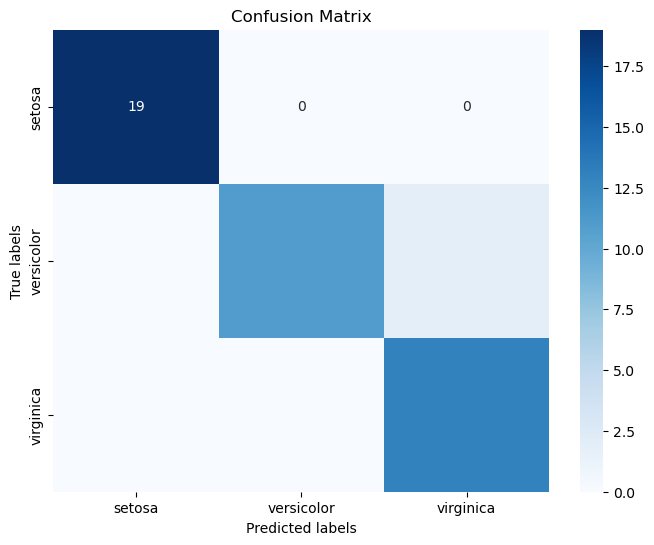

In [27]:
predictions = [airs_csa.classify(antigen) for antigen in X_test]

# Calculate the confusion matrix
cm = confusion_matrix(y_test, predictions)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=iris.target_names, yticklabels=iris.target_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()